In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Generate New Images from existing

In [2]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [14]:
img = load_img('data\\test\\unhealthy\\masked_38.jpg')  # this is a PIL image

In [19]:
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x.shape

(2048, 1152, 3)

In [18]:
x = x.reshape((150, 150, 3))  # this is a Numpy array with shape (1, 3, 150, 150)

ValueError: cannot reshape array of size 7077888 into shape (150,150,3)

In [16]:
x.shape

(1, 2048, 1152, 3)

In [8]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/rust_generated', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [17]:
model.predict(x)

ValueError: Error when checking input: expected conv2d_1_input to have shape (150, 150, 3) but got array with shape (2048, 1152, 3)

### Train Keras model

In [2]:
img_shape = (150, 150)

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=img_shape + (3,)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [4]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [5]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=img_shape,  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=img_shape,
        batch_size=batch_size,
        class_mode='binary')

Found 1247 images belonging to 2 classes.
Found 313 images belonging to 2 classes.


In [308]:
lr_schedule = LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [7]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=800 // batch_size, 
    #callbacks=[lr_schedule],
)

Epoch 1/50
125/125 [==============================] - 96s 770ms/step - loss: 0.6539 - accuracy: 0.6301 - val_loss: 0.5896 - val_accuracy: 0.6298
Epoch 2/50
125/125 [==============================] - 89s 716ms/step - loss: 0.6313 - accuracy: 0.6513 - val_loss: 0.4833 - val_accuracy: 0.6765
Epoch 3/50
125/125 [==============================] - 90s 721ms/step - loss: 0.6259 - accuracy: 0.6617 - val_loss: 0.6511 - val_accuracy: 0.7226
Epoch 4/50
125/125 [==============================] - 90s 716ms/step - loss: 0.6041 - accuracy: 0.6808 - val_loss: 0.3778 - val_accuracy: 0.7548
Epoch 5/50
125/125 [==============================] - 92s 737ms/step - loss: 0.5820 - accuracy: 0.7002 - val_loss: 0.3904 - val_accuracy: 0.7443
Epoch 6/50
125/125 [==============================] - 89s 715ms/step - loss: 0.5545 - accuracy: 0.7239 - val_loss: 0.5970 - val_accuracy: 0.7574
Epoch 7/50
125/125 [==============================] - 89s 714ms/step - loss: 0.5272 - accuracy: 0.7427 - val_loss: 0.6384 - val_ac

[1e-08, 0.0001, 0, 0.5]

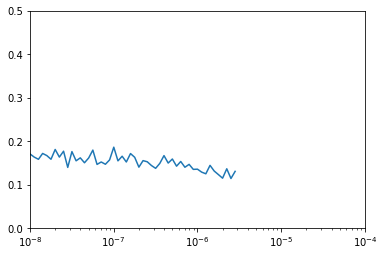

In [313]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, .5])

In [10]:
model.evaluate_generator(validation_generator)

[0.5416428446769714, 0.9424920082092285]

In [309]:
model.save('latest_model.h5')

In [18]:
#model.save_weights('first_try.h5')  # always save your weights after training or during training

In [2]:
#model = load_model('classification.h5')

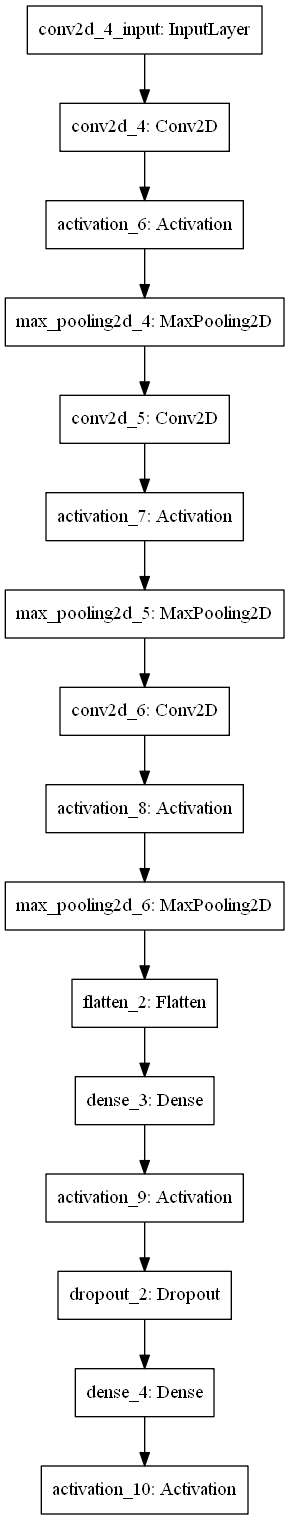

In [7]:
#plot_model(model)

In [321]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [322]:
test_predict = test_datagen.flow_from_directory(
        'data/test/',  # this is the target directory
        target_size=img_shape,  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 313 images belonging to 2 classes.


In [319]:
def prediction_results(pic):
    predictions = model.predict(pic[0])
    predict_class = model.predict_classes(pic[0])
    predict_class = [float(i[0]) for i in predict_class]
    predict_class = list(zip(pic[1], predict_class))
    correct = sum([p == i for p, i in predict_class])/16
    return correct

In [320]:
results = []
for i, pic in enumerate(test_predict):
    results.append(prediction_results(pic))
    if i > 50:
        break

In [300]:
print(results)

[0.8125, 1.0, 0.9375, 1.0, 1.0, 0.5625, 0.9375, 0.9375, 0.875, 0.875, 1.0, 0.9375, 0.8125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9375, 0.875, 1.0, 1.0, 1.0, 0.4375, 0.9375, 0.9375, 1.0, 0.9375, 0.875, 0.9375, 0.9375, 1.0, 1.0, 0.9375, 1.0, 0.9375, 1.0, 1.0, 0.9375, 0.875, 1.0, 0.875, 1.0, 0.5, 0.9375, 0.9375, 0.875, 1.0, 0.875, 1.0]


In [301]:
sum(results)/len(results)

0.9266826923076923

In [262]:
np.shape(pic[0][2])

(150, 150, 3)

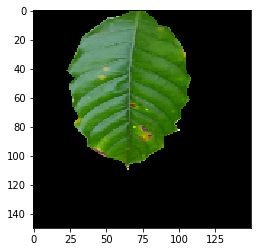

In [286]:
plt.imshow(pic[0][5]);

In [8]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

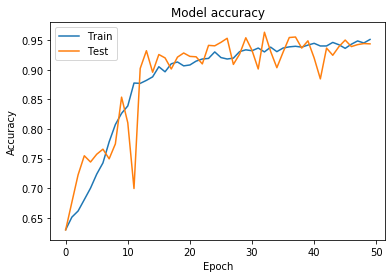

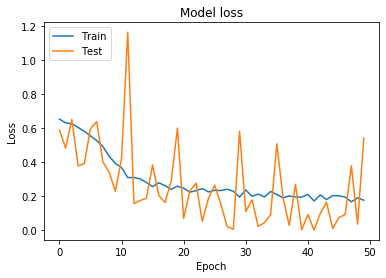

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [302]:
history.history['lr']

KeyError: 'lr'